# Main Cancers Deaths in Men 

### Table of Contents  

- <a href = "#intro">Introduction </a>  
- <a href = "#wrangling">Data Wrangling </a> 
- <a href = "#">Exploratory Data Analysis </a>  
- <a href = "#conclusion">Conclusions </a>   


<h2 id = "intro"> Introduction</h2>






In [56]:
# Imports all the needed packages for the project
import pandas as pd                # imports the package for the dataframes
import numpy as np                 # imports the package for the arrays
import matplotlib.style as style    # imports the package for the plot
import folium                      # imports the package For the world map
style.use("fivethirtyeight")
%matplotlib inline 

<h2 id ="wrangling">Data Wrangling </h2>  
First of all we import all the separated files and gather it in one unique dataset.  

### General Properties

In [57]:
## Load all the files 
liver_df = pd.read_csv("files/liver_cancer_number_of_male_deaths.csv")        # load liver file
lung_df = pd.read_csv("files/lung_cancer_number_of_male_deaths.csv")          # load lung file
prostate_df = pd.read_csv("files/prostate_cancer_number_of_male_deaths.csv")  # load prostate file
stomach_df = pd.read_csv("files/stomach_cancer_number_of_male_deaths.csv")    # load stomach file

# Check thr structure of the files
liver_df.head(2) 

,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,124.0,134.0,146.0,161.0,176.0,191.0,199.0,206.0,211.0,...,301.0,312.0,324.0,337.0,350.0,366.0,384.0,402.0,421.0,440.0
1,Albania,149.0,155.0,160.0,164.0,170.0,182.0,192.0,199.0,209.0,...,201.0,201.0,205.0,213.0,219.0,225.0,231.0,238.0,246.0,251.0


In [58]:
lung_df.head(2)

,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,577.0,621.0,678.0,748.0,822.0,888.0,927.0,955.0,979.0,...,1390.0,1430.0,1460.0,1510.0,1560.0,1620.0,1690.0,1760.0,1840.0,1930.0
1,Albania,471.0,478.0,477.0,478.0,482.0,497.0,510.0,533.0,559.0,...,699.0,716.0,731.0,736.0,741.0,750.0,763.0,781.0,801.0,818.0


In [59]:
prostate_df.head(2)

,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,130.0,140.0,152.0,168.0,185.0,201.0,211.0,220.0,226.0,...,326.0,336.0,347.0,360.0,372.0,386.0,400.0,416.0,432.0,456.0
1,Albania,149.0,152.0,154.0,155.0,157.0,160.0,164.0,169.0,177.0,...,253.0,264.0,277.0,287.0,293.0,300.0,308.0,317.0,326.0,337.0


In [60]:
stomach_df.head(2)

,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,482.0,519.0,568.0,630.0,698.0,758.0,797.0,826.0,850.0,...,1180.0,1200.0,1210.0,1230.0,1250.0,1280.0,1310.0,1350.0,1400.0,1450.0
1,Albania,207.0,213.0,216.0,216.0,218.0,224.0,230.0,240.0,252.0,...,305.0,308.0,311.0,311.0,308.0,308.0,310.0,314.0,319.0,323.0


In [61]:
# Transform the files from wide to long
def gather(df,value_name:str) -> "df": # Define the function gather that will return a dataframe
    """function to transform and rename the columns """
    # Transform and rename in a row with the melt methods 
    df = df.melt(id_vars = ["country"],var_name = "year", value_name = value_name) 
    return df

# Use the gather function to transform each file 
liver_long = gather(liver_df, "liver_deaths")          # Transform liver_df to liver_long
lung_long = gather(lung_df, "lung_deaths")             # Transform lung_df to lung_long
stomach_long = gather(stomach_df, "stomach_deaths")    # Transform stomach_df to stomach_long
prostate_long = gather(prostate_df, "prostate_deaths") # transform prostate_df to prostate_long
liver_long.head() # Check the first 5 rows 

,country,year,liver_deaths
0,Afghanistan,1990,124.00
1,Albania,1990,149.00
2,Algeria,1990,215.00
3,Andorra,1990,1.25
4,Angola,1990,302.00


In [62]:
# Check the files to see if all is correct 
prostate_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5049 entries, 0 to 5048
Data columns (total 3 columns):
country            5049 non-null object
year               5049 non-null object
prostate_deaths    5049 non-null float64
dtypes: float64(1), object(2)
memory usage: 118.4+ KB


Now that our file are ok, let put it all together in one unique dataframe

In [63]:
cancers_df = liver_long  # Create a new dataframe with all the values of liver_long dataframe 
cancers_df["lung_deaths"] = lung_long.lung_deaths  # Add the new column lung_deaths with its value from lung_long df
cancers_df["stomach_deaths"] = stomach_long.stomach_deaths    # Add the new column stomach_deaths with its values from stomach_long df 
cancers_df["prostate_deaths"] = prostate_long.prostate_deaths #Add the new column prostate_deaths with its values from prostate_long df 
cancers_df.head()  # Check the first few rows

,country,year,liver_deaths,lung_deaths,stomach_deaths,prostate_deaths
0,Afghanistan,1990,124.00,577.0,482.00,130.00
1,Albania,1990,149.00,471.0,207.00,149.00
2,Algeria,1990,215.00,1150.0,650.00,261.00
3,Andorra,1990,1.25,13.7,4.02,7.16
4,Angola,1990,302.00,268.0,283.00,233.00


In [64]:
# Check the info of the finale data 
cancers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5049 entries, 0 to 5048
Data columns (total 6 columns):
country            5049 non-null object
year               5049 non-null object
liver_deaths       5049 non-null float64
lung_deaths        5049 non-null float64
stomach_deaths     5049 non-null float64
prostate_deaths    5049 non-null float64
dtypes: float64(4), object(2)
memory usage: 236.8+ KB


Checking the info of the final dataframe, we can see that there are no missing values, the data types are correct
we have a clean data. Let's see some statistic to have an overview


In [65]:
cancers_df.describe()

,liver_deaths,lung_deaths,stomach_deaths,prostate_deaths
count,5049.000000,5049.000000,5049.000000,5049.000000
mean,2413.228984,5105.906282,2724.360368,1470.019778
std,19456.176523,24621.169653,17347.627108,3670.981779
min,0.610000,2.260000,1.150000,0.820000
25%,46.100000,94.900000,56.600000,69.500000
50%,205.000000,434.000000,331.000000,308.000000
75%,687.000000,2140.000000,999.000000,1170.000000
max,324000.000000,424000.000000,257000.000000,35500.000000


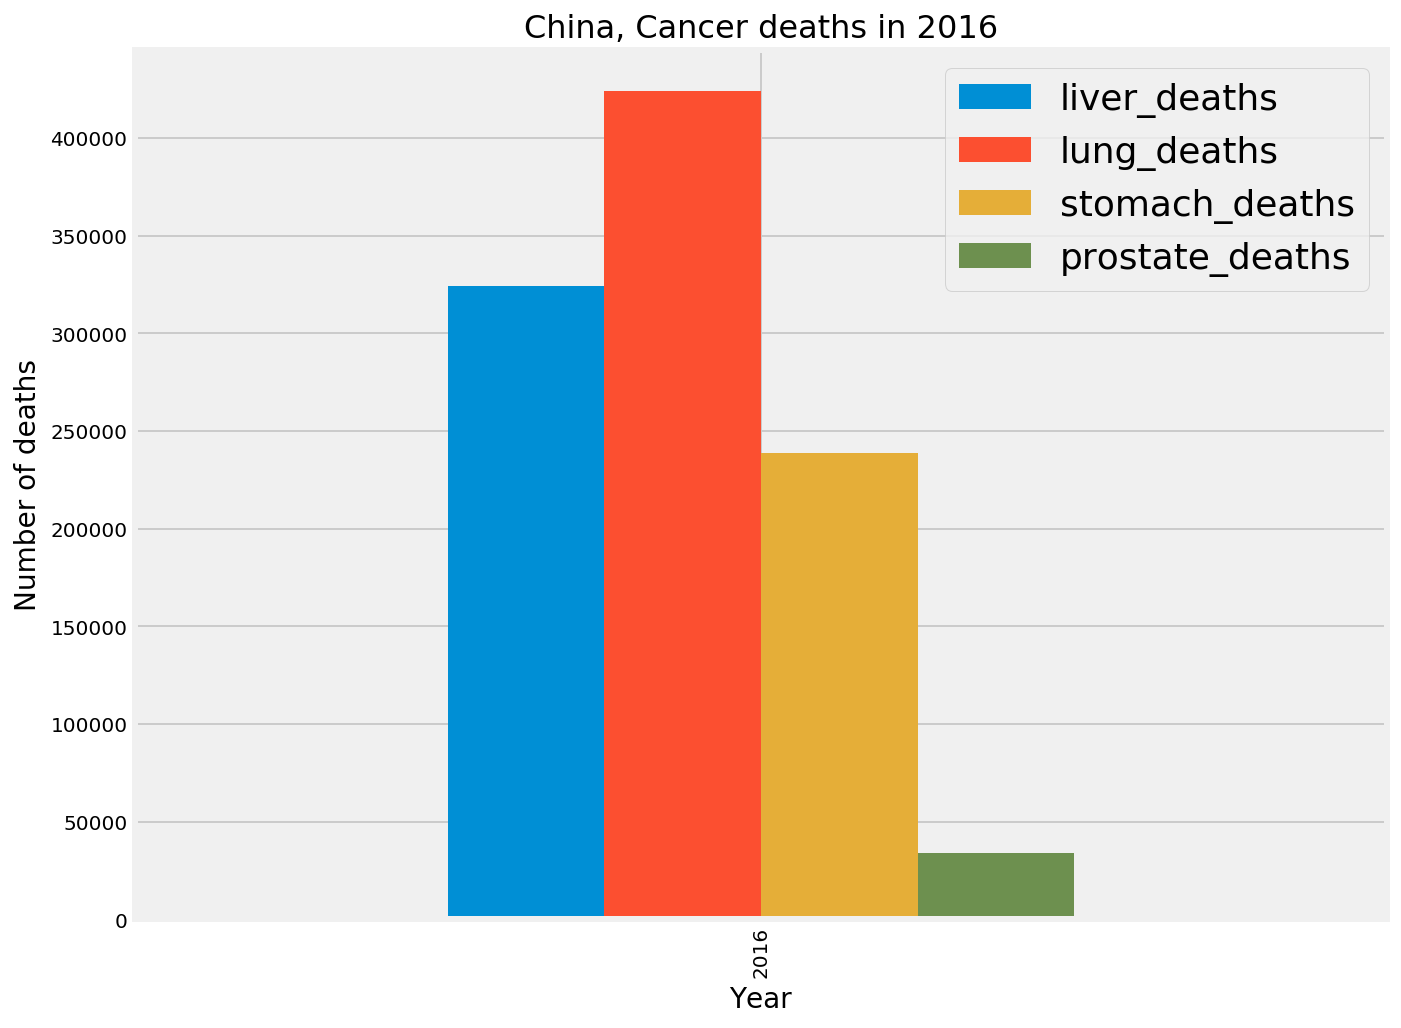

In [73]:
cancers_max_plt = cancers_df[cancers_df.lung_deaths == max(cancers_df.lung_deaths)].plot(kind = "bar", x = "year",figsize = (10,8))
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Number of deaths", fontsize = 14)
plt.legend(fontsize = 18)
plt.title("China, Cancer deaths in 2016", fontsize = 16);

In 2016, **424000** Men dye of lung cancer just in China which is almost **12** times the number of prostate cancer deaths and almost all the population of Minneapolis city (USA).

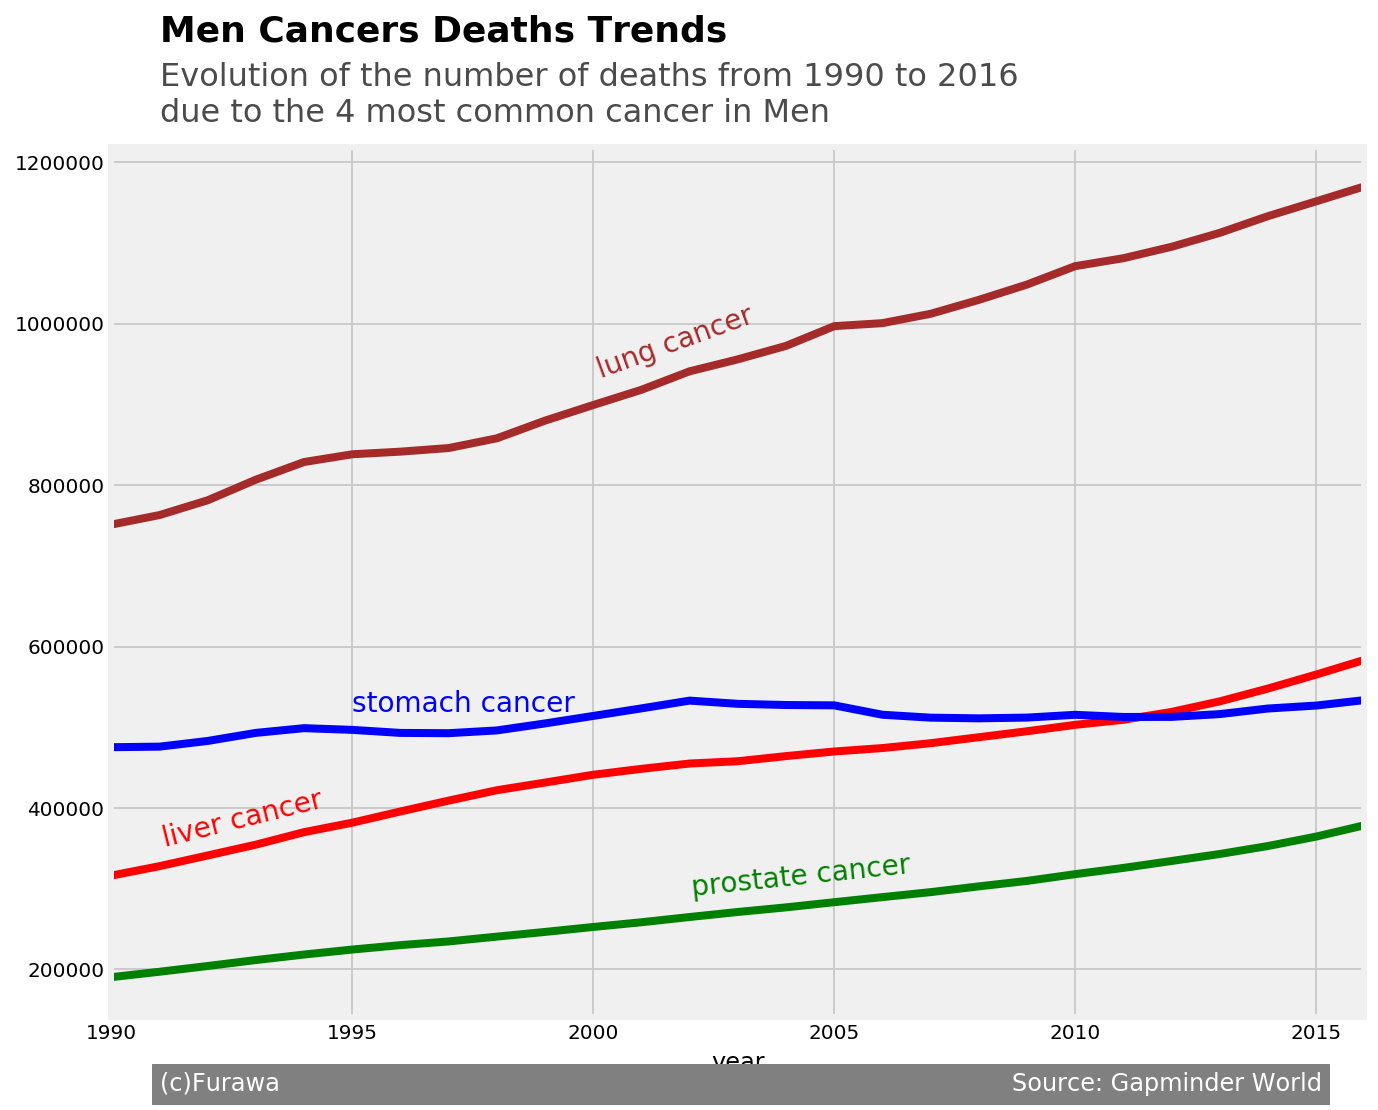

In [75]:
# Main plot: Group cancers_df by year then sum to the have total number of deaths per cancer type
cancers_trends = cancers_df.groupby("year").sum().plot(legend = False, color = ["red", "brown", "blue", "green"], figsize = (10,8))
# Adds a title 
cancers_trends.text(x = 1, y = 1350000, s = "Men Cancers Deaths Trends", fontsize = 18, weight = "bold")
# Adds a subtitle
cancers_trends.text(x = 1, y = 1250000, s = "Evolution of the number of deaths from 1990 to 2016\ndue to the 4 most common cancer in Men",
                    fontsize = 16, alpha = 0.7)
# Adds the label of each legend on the line
cancers_trends.text(x=10, y = 1000000, s = "lung cancer", fontsize = 14, rotation = 20, color = "brown")
cancers_trends.text(x=5, y = 520000, s = "stomach cancer",fontsize = 14, color = "blue")
cancers_trends.text(x=1, y = 400000, s = "liver cancer", fontsize = 14, rotation = 14, color = "red")
cancers_trends.text(x=12, y = 320000, s = "prostate cancer", fontsize = 14, rotation = 6, color = "green")
# Adds a signature bar
cancers_trends.text(x = 1, y = 50000, s = "(c)Furawa                                                                                                Source: Gapminder World",
                   fontsize = 12, backgroundcolor = "grey", color = "white");

The lung Cancer is the one which kills more people over years. In 2016 more than 1 million Men dye of lung cancer 
over the world. Except the stomach cancer deaths (which is quite stable) all the other types of cancer deaths
increase each year. 

In [68]:
world = pd.read_csv("files/worldcities.csv")
world_df = world.iloc[:,2:5]
world_df.drop_duplicates(subset = "country", keep = "first", inplace = True)
world_df.sort_values(by = "country", inplace = True)

In [76]:
cancers_2016 = cancers_df[cancers_df.year == "2016"]
cancers_2016.loc[1:,"total_deaths"] = cancers_2016.sum(axis = 1)
cancers_2016.head()

,country,year,liver_deaths,lung_deaths,stomach_deaths,prostate_deaths,total_deaths
4862,Afghanistan,2016,440.00,1930.0,1450.00,456.0,4276.00
4863,Albania,2016,251.00,818.0,323.00,337.0,1729.00
4864,Algeria,2016,440.00,1640.0,828.00,857.0,3765.00
4865,Andorra,2016,3.28,25.0,6.73,18.2,53.21
4866,Angola,2016,804.00,532.0,357.00,678.0,2371.00


In [70]:
world_map = world_df.merge(cancers_2016, how = "inner", on = "country")

In [71]:
cancer_map = folium.Map(location = [20,0], tiles = "Mapbox Bright", zoom_start = 3)

for i in range(0, len(world_map)):
    folium.Circle(
        location = [world_map.iloc[i]["lat"], world_map.iloc[i]["lng"]],
        popup = world_map.iloc[i]["country"],
        radius = world_map.iloc[i]["total_deaths"]*2,
        color = "purple",
        fill = True,
        fill_color = "purple"
    ).add_to(cancer_map)
cancer_map

<h2 id = "conclusion"> Conclusions </h2>